# Sapphire Coating Sample Transmission Measurements

This notebook provides the code necessary to collect and analyze data sampled from the LabJack U6. Here, the LJU6 is used to collect measurements from the Thorlabs PDA20H detector for characterizing the transmission profile of the Kasi Chamber Sapphire window coating samples.

Sam Condon \
SPHEREx-Test/Cal Laboratory \
Caltech \
05/04/2021

___________________________________________________________________________________________________________________

## Setup

#### Import necessary packages

In [1]:
import pandas as pd
import json
import scipy.fft as spfft
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import date
import u6
import os

#### Define class to run readout via LabJack U6

In [2]:
DETECTOR_PORT = 'AIN0'

class LabJackU6:

    def __init__(self, fs=5e3):
        # Initialize LabJack U6
        self.u6 = u6.U6()
        self.u6.getCalibrationData()
        self.fs = fs
        self.u6.streamConfig(NumChannels=2, ChannelNumbers=[0, 1], ChannelOptions=[0, 0],
                             SettlingFactor=1, ResolutionIndex=1, ScanFrequency=self.fs)

    def integrate(self, integration_time=5.0, avg=True):
        data_dict = {'Detector Voltage': []}
        detector_data = []
        start_time = time.perf_counter()
        self.u6.streamStart()
        for measure in self.u6.streamData():
            # stop condition
            if time.perf_counter() >= (start_time + integration_time):
                break

            if measure is not None and measure['errors'] == 0:
                d = measure[DETECTOR_PORT]
                if avg:
                    detector_data.append(sum(d) / len(d))
                else:
                    detector_data = detector_data + d

        self.u6.streamStop()
        data_dict['Detector Voltage'] = detector_data
        return pd.DataFrame(data_dict)
    
    def stream_stop(self):
        self.u6.streamStop()
    
    def close(self):
        self.u6.close()

#### Define plotting routine

In [3]:
#plot sample time series, histogram, and fourier transform

def plot_time_hist(t, working_samps, title='Sample'):
    fig, plts = plt.subplots(1,2, figsize=(15,5))

    plts[0].plot(t, 1e3*working_samps)
    plts[0].set_title('{} Time Series'.format(title))
    plts[0].set_xlabel('Time (s.)')
    plts[0].set_ylabel('Detector Voltage (mV.)')

    plts[1].hist(1e3*working_samps, bins=10)
    plts[1].set_title('{} Histogram'.format(title))
    plts[1].set_xlabel('Detector Voltage (mV.)')
    plts[1].set_ylabel('Occurences')

#### Define FFT routine

In [4]:
def fft(samples, fs, N=None, scale=None, ax=None, plot=True):
    if N == None:
        N = len(samples)
    if scale is not None:
        samps_fft = scale*spfft.fft(samples, n=N)
    else:
        samps_fft = spfft.fft(samples, n=N)
    
    freqs = spfft.fftshift(spfft.fftfreq(samples.size, d=1/fs))
    samps_fft = spfft.fftshift(samps_fft)
    samps_fft_mag = np.absolute(samps_fft)
    fft_dict = {'fft': samps_fft, 'fft_mags': samps_fft_mag,
                'freqs': freqs}
    
    
    if ax is None and plot:
        fft_fig, ax = plt.subplots(figsize=(10,5))
    
    if plot:
        ax.plot(fft_dict['freqs'], fft_dict['fft_mags'])
        ax.set_title('Sample FFT')
        ax.set_xlabel('Frequency (Hz.)')

    return fft_dict

#### Define routine to calculate total power in a magnitude spectrum after moving average filtering (i.e. total noise power at a given integration time)

In [5]:
def noise_power_calc(fft_mags, fft_freqs, int_t):
    #Frequency response of moving average filter applied from integration
    Hma = np.abs(np.sinc(fft_freqs*int_t))
    #Apply filtering in fourier space
    fft_mags_integrated = np.multiply(Hma, fft_mags)
    #Convert to two-sided power spectral density
    psd_integrated = (1/4)*(fft_mags_integrated**2)
    
    return np.sum(psd_integrated)

#### Define routine to save csvs and add measurement metadata to JSON file

In [6]:
def save_data(data, metadata):
    '''save_data:
            
            Parameters:
                data: dataframe corresponding to LJU6 measurement w/ detector voltage samples
                metadata: dictionary with all metadata associated with the measurement
            
            Returns:
                none, just writes csv to /data directory and metadata to JSON file
    '''
    #determine file name########################################
    count = 0
    date_str = str(date.today())
    cnt_str = str(count)
    base_str = 'data\\' + date_str + '_'
    file_name = base_str + cnt_str + '.csv'
    while os.path.exists(file_name):
        count += 1
        cnt_str = str(count)
        file_name =  base_str + cnt_str + '.csv'
    ############################################################
    
    ##save csv#########################
    data.to_csv(file_name, index=False)
    
    ##write metadata to json file############
    with open('metadata.json', 'r+') as f:
        meta_json = json.load(f)
        metadata['file-name'] = file_name
        meta_json['measurements'].append(metadata)
        f.seek(0)
        json.dump(meta_json, f, indent=2)
    ##########################################
    

## Sample New Data or Read in Existing

In [22]:

#Define metadata for the measurement
fs = 500
sample_time = 1000
measure_type = 'noise' #should be either 'signal' or 'noise'
attenuators = '4 pieces of electrical tape over detector'
monochromator_params = {'grating': 3, 'osf': 3, 'wavelength': 5.5}
lockin_params = {'time constant': 100, 'sensitivity': 20e-3, 'chop frequency': 30}
meta_dict = {'file-name': None, 'sample-frequency': fs, 'sample-time': sample_time, 'type': measure_type,
             'attenuators': attenuators, 'monochromator': monochromator_params, 'lock-in': lockin_params}

#Record new data
lju6 = LabJackU6(fs=fs)
samples = lju6.integrate(avg=False, integration_time=sample_time)
samps_arr = samples.values.flatten()

samples_nodc = samples - samples.mean()
samps_nodc_arr = samples_nodc.values.flatten()

#Save recorded samples and associated metadata
save_data(samples, meta_dict)


In [19]:
#Read existing data
file_name = 'data\\2021-05-18_20.csv'
samples_read = pd.read_csv(file_name)
samps_read_arr = samples_read.values.flatten()

samples_read_nodc = samples_read - samples_read.mean()
samps_read_nodc_arr = samples_read_nodc.values.flatten()

## Sample FFT

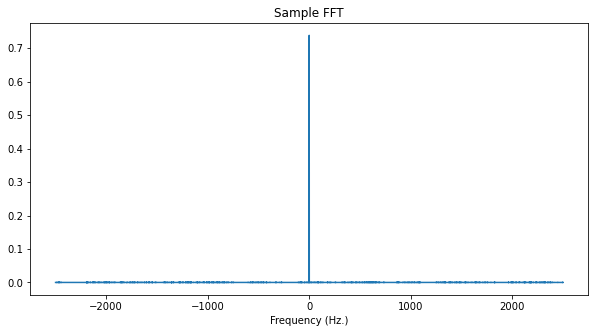

In [20]:
%matplotlib inline
working_samps = samps_read_arr
ws_len = len(working_samps)
working_samps_fft = fft(working_samps, fs, scale=(2/ws_len)) 


## Noise Power vs. Integration Time

Text(0, 0.5, 'Total noise power')

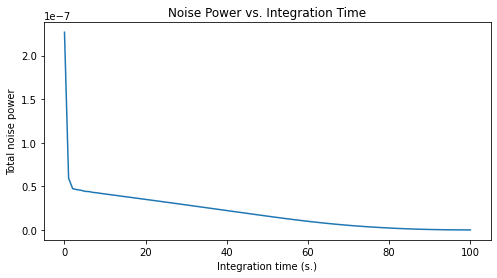

In [27]:
%matplotlib inline
integration_times = np.linspace(0.01, 100, 100)
noise_powers = []
for int_t in integration_times:
    noise_powers.append(noise_power_calc(working_samps_fft['fft_mags'], working_samps_fft['freqs'], int_t))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(integration_times, noise_powers)
ax.set_title('Noise Power vs. Integration Time')
ax.set_xlabel('Integration time (s.)')
ax.set_ylabel('Total noise power')

Save noise power vs. integration time to csv

## Verification

#### Verification of conversion from fft magnitude spectrum to power spectral density

0.13642766898348813
0.1364276689834881


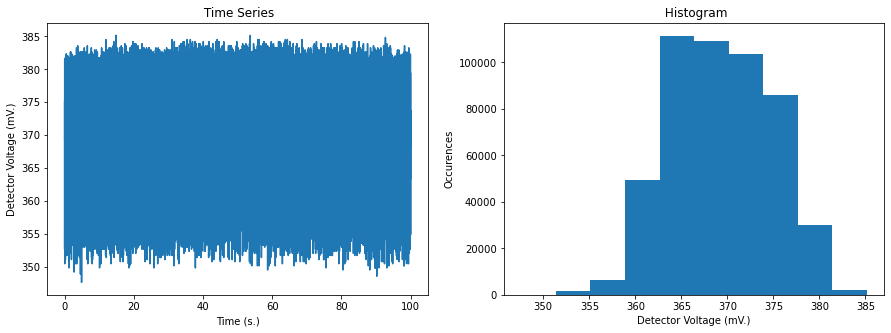

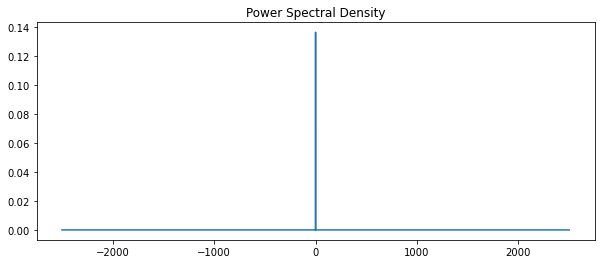

In [21]:
%matplotlib inline
ws_len = len(working_samps)
t = np.arange(0, working_samps.size*(1/fs), (1/fs))
plot_time_hist(t, working_samps, title='')
working_samps_fft = fft(working_samps, fs, scale=(2/ws_len), plot=False)
ws_psd = (1/4)*(working_samps_fft['fft_mags']**2)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(working_samps_fft['freqs'], ws_psd)
ax.set_title('Power Spectral Density')

#Verify total power in time series and power spectral density match
noise_power_time = np.mean(working_samps**2)
noise_power_freq = np.sum(ws_psd)

print(noise_power_time)
print(noise_power_freq)

#### Verification of noise_power_calc routine

In [30]:
int_t = .005

#Generate moving average filter corresponding to given integration time and perform filtering in time
ma_N = int(int_t*fs)
ma_filter = (1/ma_N)*np.ones(ma_N)
ma_filter_fft = fft(ma_filter, fs, N=ws_len, plot=False)
ws_integrated = np.convolve(ma_filter, working_samps)


#Generate sinc function corresponding to frequency response of moving average filter from above
f = working_samps_fft['freqs']
ws_fft_mags = working_samps_fft['fft_mags']
int_sinc = np.abs(np.sinc(f*int_t))
ws_fft_integrated = np.multiply(int_sinc, ws_fft_mags)

#Convert to power spectral density
ws_psd_integrated = (1/4)*(ws_fft_integrated**2)

#Verify that total noise power in time and frequency agree after filtering
integrated_noise_power_time = np.mean(ws_integrated**2)
integrated_noise_power_freq = np.sum(ws_psd_integrated)
test = noise_power_calc(ws_fft_mags, f, int_t)

print(integrated_noise_power_time)
print(integrated_noise_power_freq)
print(test)


3.4507974966872077e-07
3.412442832158595e-07
3.412442832158595e-07


#### Compare noise power vs. integration time plots

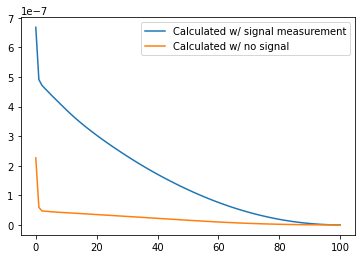

In [80]:
%matplotlib inline

NpVInt_sig = pd.read_csv('data\\2021-05-11_100_5000_4_NpVInt.csv')
NpVInt_nosig = pd.read_csv('data\\2021-05-11_100_5000_6_NpVInt.csv')

t = NpVInt_sig['Integration Time'].values
d1 = NpVInt_sig['Noise Power'].values
d2 = NpVInt_nosig['Noise Power'].values

fig, ax = plt.subplots()
ax.plot(t, d1, label='Calculated w/ signal measurement')
ax.plot(t, d2, label='Calculated w/ no signal')
ax.legend()

In [25]:
np.linspace(0.75, 5.0, 10)

array([0.75      , 1.22222222, 1.69444444, 2.16666667, 2.63888889,
       3.11111111, 3.58333333, 4.05555556, 4.52777778, 5.        ])